In [1]:
from cnn_gp import Sequential, Conv2d, ReLU, NormalizationModule
import torch
import timeit
import numpy as np
from numpy import linalg as la
import random
import math
import timeit

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

from utils_bounds import calc_kernel_selector, calc_toeplitz
from utils_gp import calc_kernel,calc_cross_kernel,generate_model
from Bound_eval_functions import calc_upper_bound,calc_lower_bound,calc_bound
from utils import solve_system,calc_accuracy

C:\Users\cedri\AppData\Local\Temp\ipykernel_10520\2395490487.py:12: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


Read MNIST Dataset

In [2]:
#Generate DataSets
num_train = 1000
num_test = 1000

def generate_one_hot_neg(Y,n_classes):
    Y_hot = torch.ones(len(Y), n_classes, dtype=torch.float64).neg_()  # all -1
    Y_hot[torch.arange(len(Y)), Y] = 1.
    return Y_hot

##load and transform data
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

train_images = train_data.data[0:num_train]
train_labels = generate_one_hot_neg(train_data.targets[0:num_train],10)
test_images = test_data.data[0:num_test]
test_labels = test_data.targets[0:num_test]
train_images = train_images.view(num_train,1,28,28).double()
test_images = test_images.view(num_test,1,28,28).double()
print("train_images size: ",train_images.size())

train_images size:  torch.Size([1000, 1, 28, 28])


Calculate Eigenvalue decomposition of toeplitz matrix

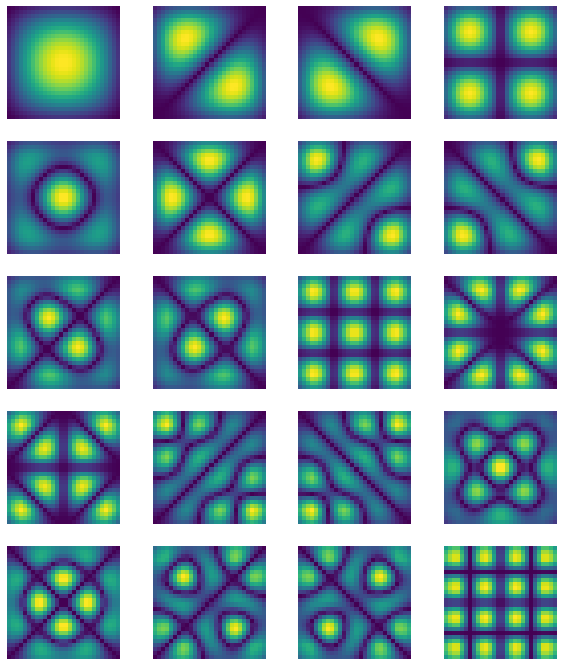

In [3]:
kernel = np.ones((7,7))
toep = calc_toeplitz(kernel,in_size=(34,34),out_size=(28,28),true_in_size=(28,28))
toep[toep==-1] = 0

w, v =la.eig(toep)
w = np.abs(w)
eig_max = np.real(max(w))
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]
q1 = np.abs(np.real(v[:,0].reshape(-1,1)))
projection = q1@q1.T


fig = plt.figure(figsize=(10,12))
columns = 4 # if more that
rows = 5
for i in range(1, columns*rows +1):
    img = np.abs(np.real(v[:,i-1].reshape(-1,1))).reshape(28,28)
    ax = fig.add_subplot(rows, columns, i)
    ax.imshow(img)
    ax.axis("off")
plt.show()

Display bounds function

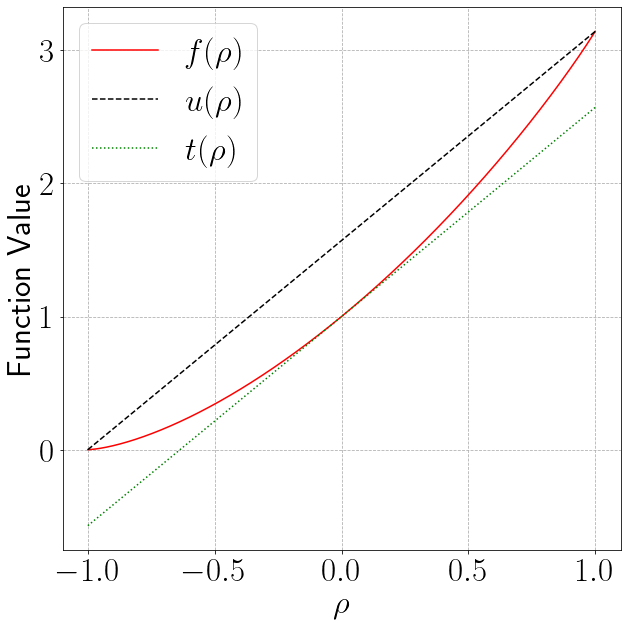

In [4]:
def f(x):
    return np.sqrt(1-x**2)+(np.pi-np.arccos(x))*x
def f_low(x):
    return 1+np.pi/2*x
def f_up(x):
    return np.pi/2+np.pi/2*x 
x = np.array([0.001*k for k in range(-1000,1001)])

fig = plt.figure(figsize=(10,10))
axs = fig.subplots(1, 1) 

axs.plot(x, f(x),"-",label = r'$f(\rho)$',color="red")
axs.plot(x, f_up(x),"--",label = r"$u(\rho)$",color="black")
axs.plot(x, f_low(x),":",label = r"$t(\rho)$",color="green")
axs.legend(loc='best',prop={'size': 33})
axs.set_xlabel(r"$\rho$",size=33)
axs.set_ylabel(r"Function Value",size=33)
axs.grid(which="both",linestyle="--")
axs.tick_params(axis='both', which='major', labelsize=33) 

Approximation helper function

In [5]:
X = train_images[0:1].numpy().reshape(-1,1)
X_prime = train_images[1:2].numpy().reshape(-1,1)
def approximator(L,sig_w):
    W_l = np.ones(784)*sig_w
    z = np.sqrt((q1.T@(X**2))*(q1.T@(X_prime**2)))
    term1 = ((eig_max*sig_w)/2)**L*(W_l@(q1@z))
    term2 = ((eig_max*sig_w)/4)**L*(W_l@(projection@(X*X_prime)))
    return (term1+term2).item()

def without_approx():
    W_l = np.ones(784)*2./eig_max
    z = np.sqrt((q1.T@(X**2))*(q1.T@(X_prime**2)))
    return (W_l@(q1@z))

Bias contribution

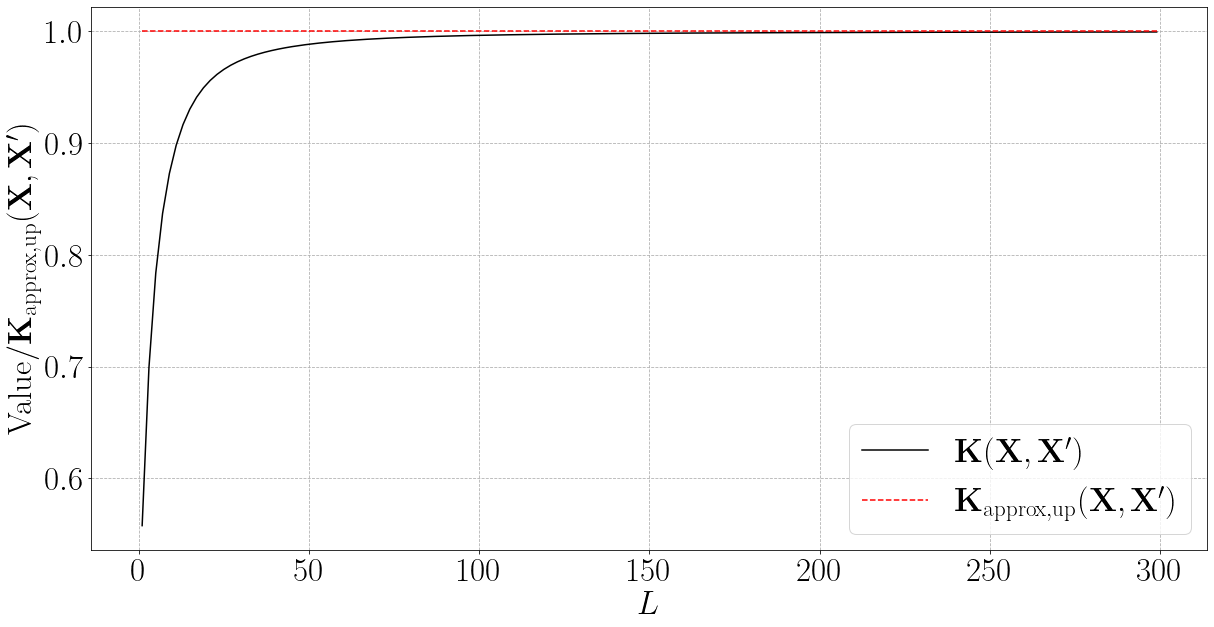

In [6]:
K = np.array([calc_cross_kernel(X=train_images[0:1],Y=train_images[1:2],model=generate_model(kernel_size=7,normalize=False,relu=True,num_layers=l,var_weight=2./eig_max,var_bias=0.).double()).item() for l in range(1,300,2)])

xnew = list(range(1,300,2))
fig = plt.figure(figsize=(20,10))
axs = fig.subplots(1, 1) 

axs.plot(xnew[:], K/without_approx(),"-",label = r'$\mathbf{K}(\mathbf{X},\mathbf{X}^\prime)$',color="black")
axs.plot(xnew[:], np.ones(len(xnew)),"--",label = r'$\mathbf{K}_{\mathrm{approx,up}}(\mathbf{X},\mathbf{X}^\prime)$',color="red")
axs.legend(loc='best',prop={'size': 33})
axs.set_xlabel(r"$L$",size=33)
axs.set_ylabel(r"$\mathrm{Value}/\mathbf{K}_{\mathrm{approx,up}}(\mathbf{X},\mathbf{X}^\prime)$",size=33)
axs.grid(which="both",linestyle="--")
axs.tick_params(axis='both', which='major', labelsize=33) 


Test of upper and lower bound

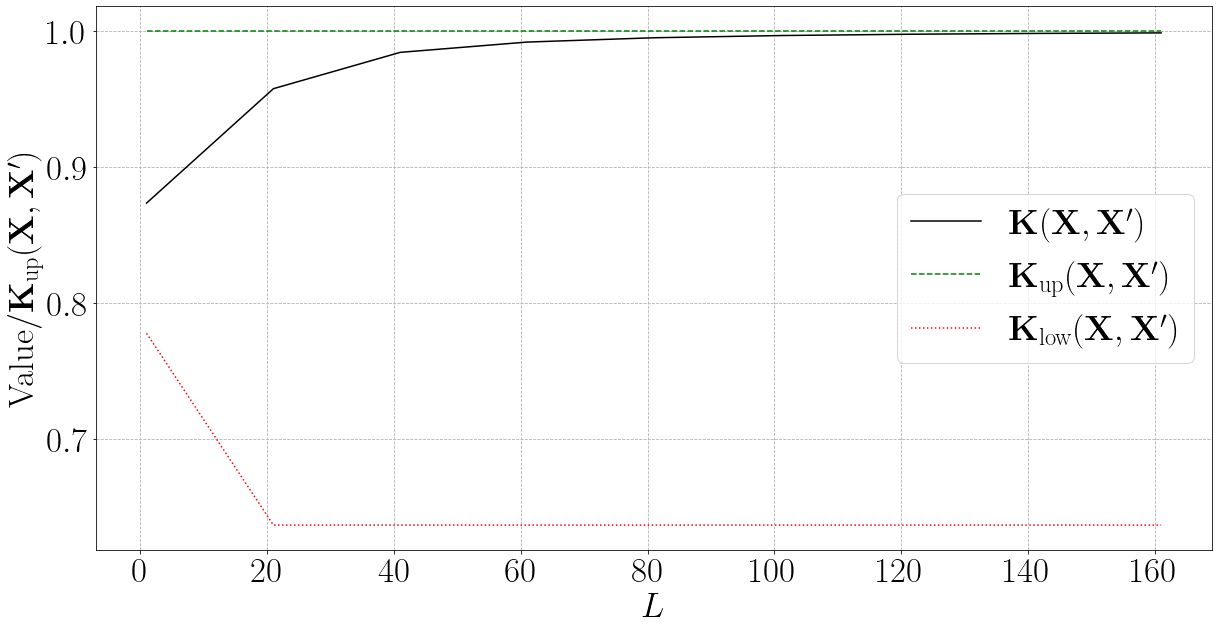

In [14]:
K = []
K_up = []
K_low = []
for l in range(1,180,20):
    K_up.append(calc_upper_bound(X=train_images[0:1],Y=train_images[1:2],l=l,sig_w=0.25).item())
    K_low.append(calc_lower_bound(X=train_images[0:1],Y=train_images[1:2],l=l,sig_w=0.25).item())
K_up = np.array(K_up)
K_low = np.array(K_low)

K1 = []
K2 = []
for l in range(1,180,20):
    K1.append(calc_cross_kernel(X=train_images[0:1],Y=train_images[1:2],model=generate_model(kernel_size=7,normalize=False,relu=True,num_layers=l,var_weight=0.25,var_bias=0.).double()).item())
    K2.append(calc_cross_kernel(X=train_images[0:1],Y=train_images[1:2],model=generate_model(kernel_size=7,normalize=False,relu=True,num_layers=l,var_weight=0.25,var_bias=20).double()).item())
K1 =np.array(K1)
K2 =np.array(K2)

xnew = list(range(1,180,20))
fig = plt.figure(figsize=(20,10))
axs = fig.subplots(1, 1) 

axs.plot(xnew[:], K1/K_up[:],"-",label = r'$\mathbf{K}(\mathbf{X},\mathbf{X}^\prime)$',color="black")
axs.plot(xnew[:], K_up[:]/K_up[:],"--",label = r'$\mathbf{K}_{\mathrm{up}}(\mathbf{X},\mathbf{X}^\prime)$',color="green")
axs.plot(xnew[:], K_low[:]/K_up[:],":",label = r'$\mathbf{K}_{\mathrm{low}}(\mathbf{X},\mathbf{X}^\prime)$',color="red")
axs.legend(loc='best',prop={'size': 35})
axs.set_xlabel(r"$L$",size=35)
axs.set_ylabel(r"$\mathrm{Value}/\mathbf{K}_{\mathrm{up}}(\mathbf{X},\mathbf{X}^\prime)$ ",size=35)
axs.grid(which="both",linestyle="--")
axs.tick_params(axis='both', which='major', labelsize=35) 

Examine convergence against upper bound

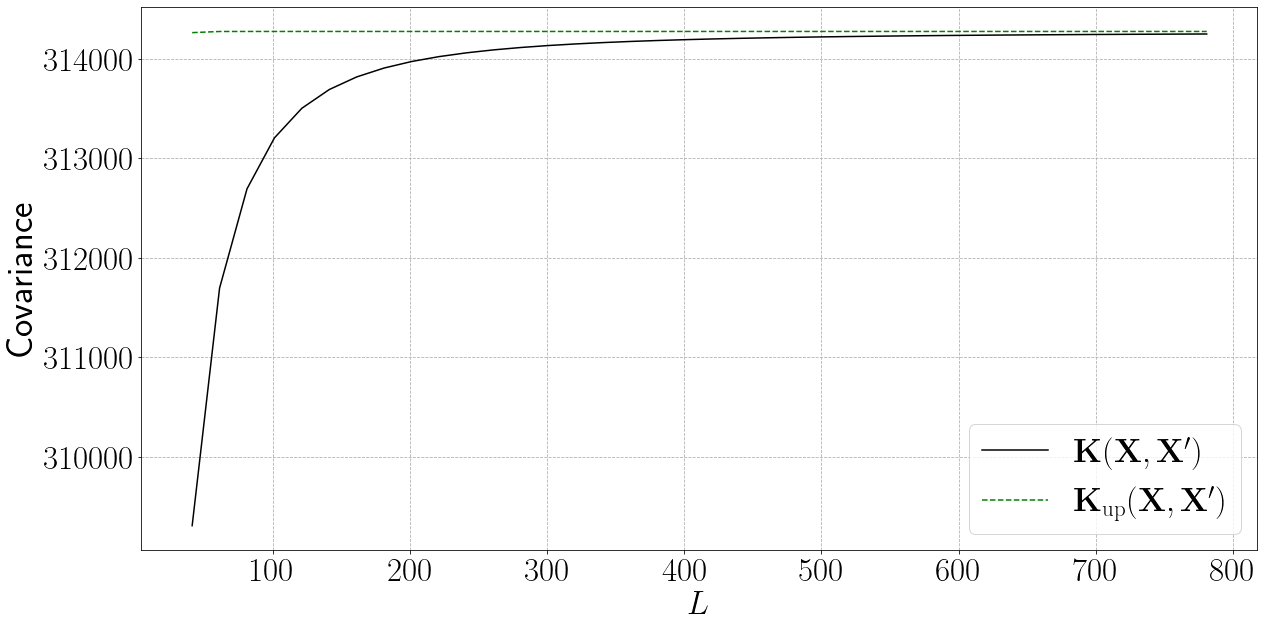

In [11]:
K = [calc_cross_kernel(X=train_images[0:3],Y=train_images[0:3],model=generate_model(kernel_size=7,normalize=False,relu=True,num_layers=l,var_weight=2/eig_max,var_bias=0.)) for l in range(1,800,20)]
K_up = [calc_upper_bound(X=train_images[0:3],Y=train_images[0:3],l=l,sig_w=2/(eig_max)) for l in range(1,800,20)]
K_low = [calc_lower_bound(X=train_images[0:3],Y=train_images[0:3],l=l,sig_w=2/(eig_max)) for l in range(1,800,20)]

y_1 = np.array([zw[0,0].item() for zw in K])
y_2 = [zw[0,1].item() for zw in K]
y_3 = [zw[1,2].item() for zw in K]
y_up_1 = np.array([zw[0,0].item() for zw in K_up])
y_up_2 = [zw[0,1].item() for zw in K_up]
y_up_3 = [zw[1,2].item() for zw in K_up]
y_low_1 = [zw[0,0].item() for zw in K_low]
y_low_2 = [zw[0,1].item() for zw in K_low]
y_low_3 = [zw[1,2].item() for zw in K_low]

xnew = list(range(1,800,20))
fig = plt.figure(figsize=(20,10))
axs = fig.subplots(1, 1) 
axs.plot(xnew[2:], y_2[2:],"-",label = r'$\mathbf{K}(\mathbf{X},\mathbf{X}^\prime)$',color="black")
axs.plot(xnew[2:], y_up_2[2:],"--",label = r'$\mathbf{K}_{\mathrm{up}}(\mathbf{X},\mathbf{X}^\prime)$',color="green") #\mathbf{K}_\text{up}(\mathbf{X},\mathbf{X}^\prime)
axs.legend(loc='best',prop={'size': 33})
axs.set_xlabel(r"$L$",size=33)
axs.set_ylabel(r"Covariance",size=37)
axs.grid(which="both",linestyle="--")
axs.tick_params(axis='both', which='major', labelsize=33) 

Check convergence of GP predictor

10
25
50
100
200
400
800
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine


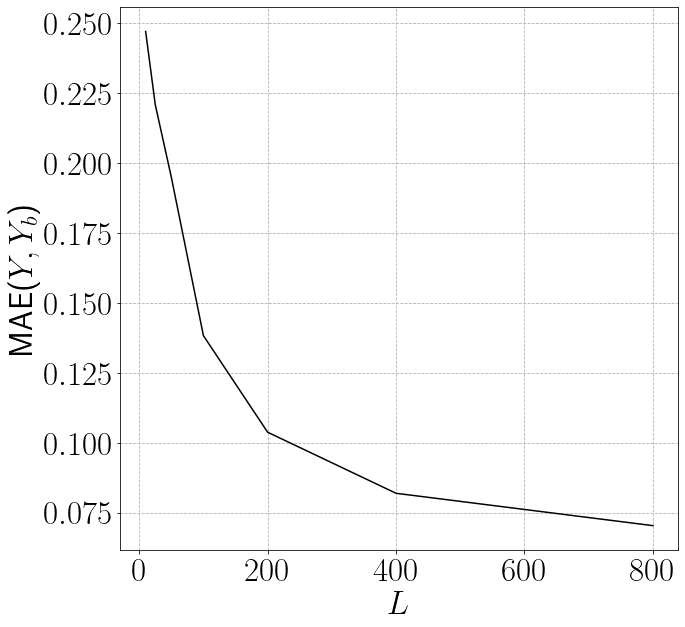

In [13]:
ls = [10,25,50,100,200,400,800]
results_bound_cross = []
results_bound_self = []
results_real_self = []
results_real_cross = []
for l in ls:
    print(l)
    results_real_self.append(calc_cross_kernel(X=train_images[0:80],Y=train_images[0:80],model=generate_model(kernel_size=7,normalize=False,relu=True,num_layers=l,var_weight=2/eig_max,var_bias=0.)))
    results_bound_self.append(calc_upper_bound(X=train_images[0:80],Y=train_images[0:80],l=l,sig_w=2/eig_max))
    results_real_cross.append(calc_cross_kernel(X=train_images[0:80],Y=test_images[0:30],model=generate_model(kernel_size=7,normalize=False,relu=True,num_layers=l,var_weight=2/eig_max,var_bias=0.)))
    results_bound_cross.append(calc_upper_bound(X=train_images[0:80],Y=test_images[0:30],l=l,sig_w=2/eig_max))

A_bounds = [solve_system(K,train_labels[0:80].numpy()) for K in results_bound_self]
A_reals = [solve_system(K,train_labels[0:80]) for K in results_real_self]
Sol_bounds = [np.array(results_bound_cross[i].T @ A_bounds[i]) for i in range(len(results_bound_self))]
Sol_reals = [np.array((results_real_cross[i].T @ A_reals[i])) for i in range(len(results_real_self))]
means_mae = [np.mean(np.power(np.abs(Sol_bounds[i]-Sol_reals[i]),1)) for i in range(len(Sol_reals))]
means_div = [np.mean(np.power(np.abs(Sol_bounds[i]/Sol_reals[i]),1)) for i in range(len(Sol_reals))]
means_rmse = [np.sqrt(np.mean(np.power(np.abs(Sol_bounds[i]-Sol_reals[i]),2))) for i in range(len(Sol_reals))]


fig = plt.figure(figsize=(10,10))
axs = fig.subplots(1, 1) 

axs.plot(ls, means_mae,"-",label = r'mae',color="black")
axs.set_xlabel(r"$L$",size=33)
axs.set_ylabel(r"MAE($Y,Y_{b}$)",size=33)
axs.grid(which="both",linestyle="--")
axs.tick_params(axis='both', which='major', labelsize=33) 

Test convergence of upper bound against approximation

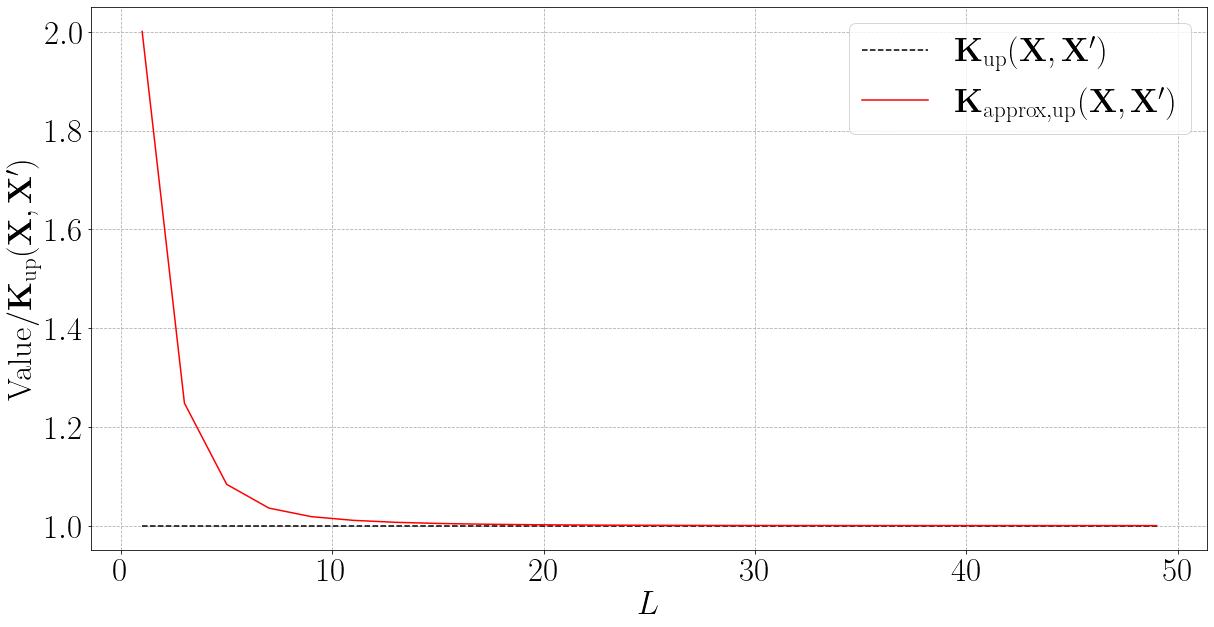

In [9]:
Approx = np.array([approximator(l,0.25) for l in range(1,50,2)])
K_up = []
for l in range(1,50,2):
    K_up.append(calc_upper_bound(X=train_images[0:1],Y=train_images[1:2],l=l,sig_w=0.25).item())
K_up = np.array(K_up)


xnew = list(range(1,50,2))
fig = plt.figure(figsize=(20,10))
axs = fig.subplots(1, 1) 

axs.plot(xnew[:], K_up/K_up,"--",label = r'$\mathbf{K}_{\mathrm{up}}(\mathbf{X},\mathbf{X}^\prime)$',color="black")
axs.plot(xnew[:], Approx/K_up[:],"-",label = r'$\mathbf{K}_{\mathrm{approx,up}}(\mathbf{X},\mathbf{X}^\prime)$',color="red")
axs.legend(loc='best',prop={'size': 33})
axs.set_xlabel(r"$L$",size=33)
axs.set_ylabel(r"$\mathrm{Value}/\mathbf{K}_{\mathrm{up}}(\mathbf{X},\mathbf{X}^\prime)$",size=33)
axs.grid(which="both",linestyle="--")
axs.tick_params(axis='both', which='major', labelsize=33) 

Test convergence of kernel function against approximation

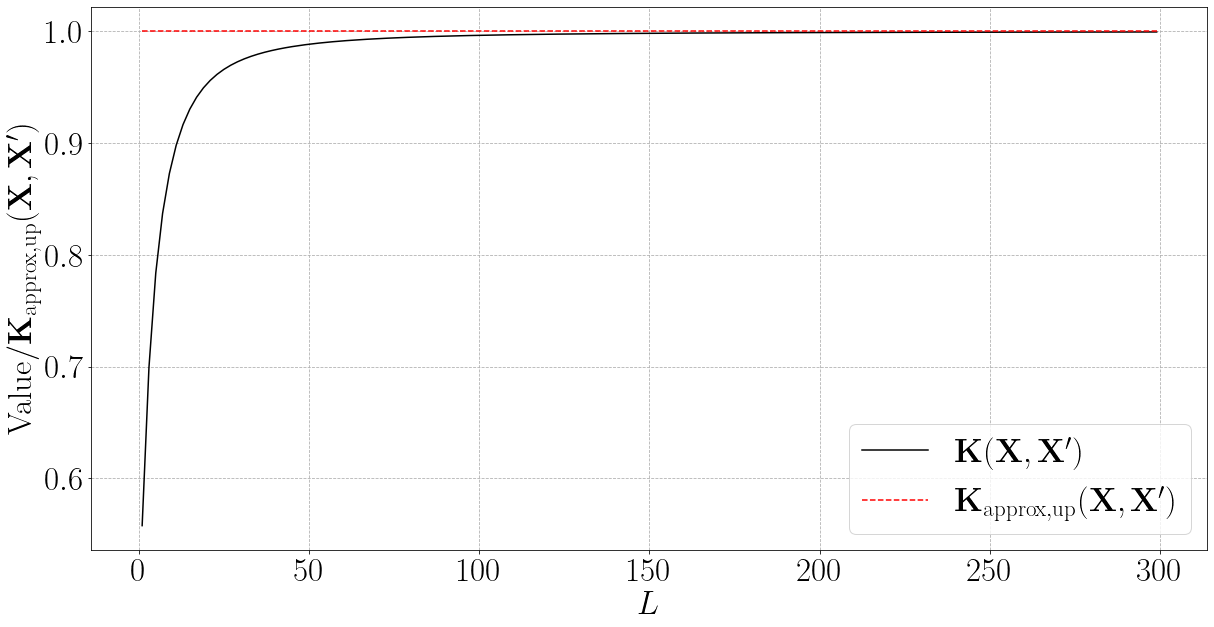

In [10]:
K = np.array([calc_cross_kernel(X=train_images[0:1],Y=train_images[1:2],model=generate_model(kernel_size=7,normalize=False,relu=True,num_layers=l,var_weight=2./eig_max,var_bias=0.).double()).item() for l in range(1,300,2)])

xnew = list(range(1,300,2))
fig = plt.figure(figsize=(20,10))
axs = fig.subplots(1, 1) 

axs.plot(xnew[:], K/without_approx(),"-",label = r'$\mathbf{K}(\mathbf{X},\mathbf{X}^\prime)$',color="black")
axs.plot(xnew[:], np.ones(len(xnew)),"--",label = r'$\mathbf{K}_{\mathrm{approx,up}}(\mathbf{X},\mathbf{X}^\prime)$',color="red")
axs.legend(loc='best',prop={'size': 33})
axs.set_xlabel(r"$L$",size=33)
axs.set_ylabel(r"$\mathrm{Value}/\mathbf{K}_{\mathrm{approx,up}}(\mathbf{X},\mathbf{X}^\prime)$",size=33)
axs.grid(which="both",linestyle="--")
axs.tick_params(axis='both', which='major', labelsize=33) 

Calculate accuracy of GP predictor with increasing layer number

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine
Running scipy solve Kxx^-1 Y routine


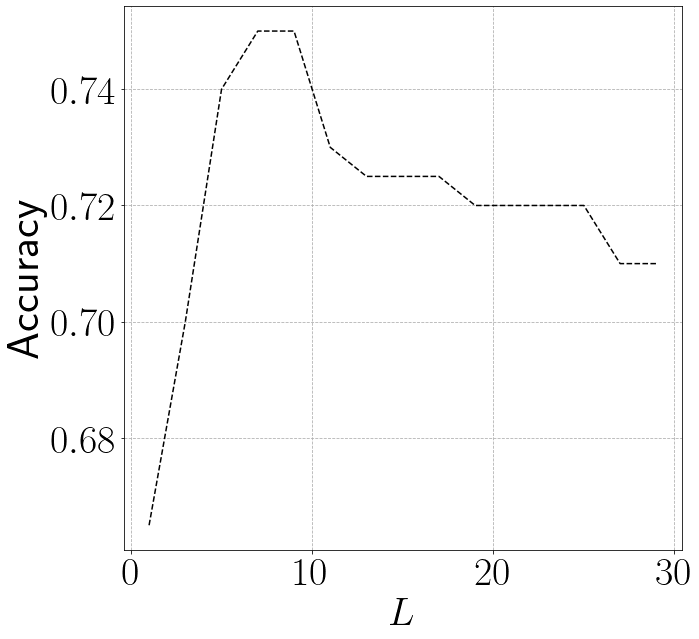

In [12]:
ls = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]
K_cross = []
K_self = []

for l in ls:
    print(l)
    K_self.append(calc_cross_kernel(X=train_images[0:100],Y=train_images[0:100],model=generate_model(kernel_size=7,normalize=False,relu=True,num_layers=l,var_weight=2.79,var_bias=7.89)))
    K_cross.append(calc_cross_kernel(X=train_images[0:100],Y=test_images[0:200],model=generate_model(kernel_size=7,normalize=False,relu=True,num_layers=l,var_weight=2.79,var_bias=7.89)))

A = [solve_system(K,train_labels[0:100]) for K in K_self]
Sol= [(K_cross[i].T @ A[i]).argmax(dim=1) for i in range(len(K_cross))]

acc = []
for Y in Sol:
    acc.append(calc_accuracy(Y,test_labels[0:200]))

fig = plt.figure(figsize=(10,10))
axs = fig.subplots(1, 1) 

axs.plot(ls, acc,"--",label = r'Covariance',color="black")
axs.set_xlabel(r"$L$",size=40)
axs.set_ylabel(r"Accuracy",size=45)
axs.grid(which="both",linestyle="--")
axs.tick_params(axis='both', which='major', labelsize=40)
